In [1]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from src.data_loader import create_tiledataloader_split
from src.model.mae import MAEUNetPretrain
from torchsummary import summary

def get_device():
    """
    Automatically selects the best available device (GPU if available, otherwise CPU).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


device = get_device()

Using MPS


### Load data tiles

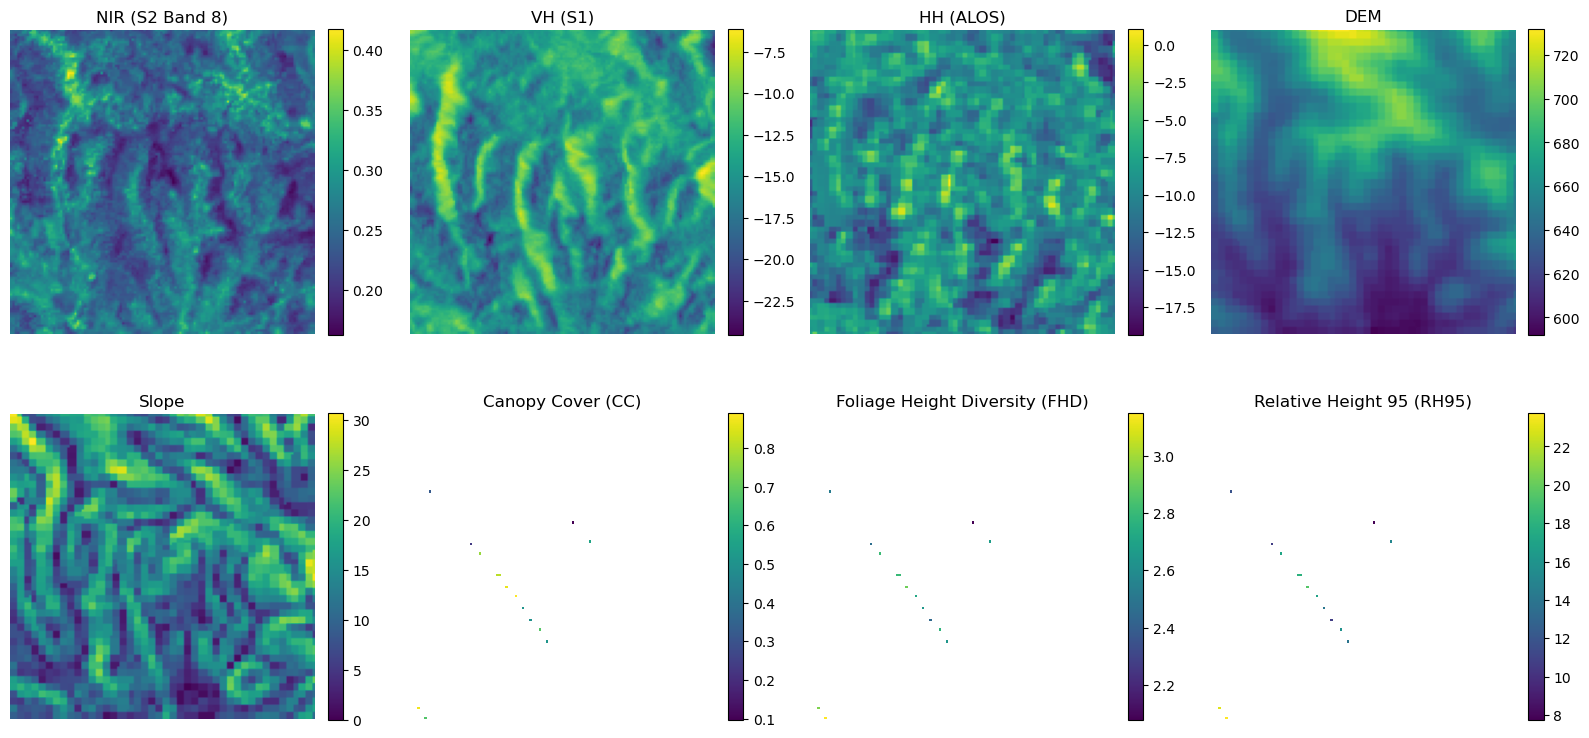

In [29]:
x = np.load("data/processed/X_tile_101.npy")
y = np.load("data/processed/y_tile_101.npy")
x_s2, x_s1, x_dem = x[0:12], x[12:18], x[18:]

images = [
    x_s2[7],  # NIR
    x_s1[1],  # VH
    10*np.log10(x_s1[4]**2)-83,  # HH
    x_dem[0], # DEM
    x_dem[1], # Slope
    y[0],     # CC
    y[1],     # FHD
    y[2]      # RH95
]

titles = [
    "NIR (S2 Band 8)",
    "VH (S1)",
    "HH (ALOS)",
    "DEM",
    "Slope",
    "Canopy Cover (CC)",
    "Foliage Height Diversity (FHD)",
    "Relative Height 95 (RH95)"
]

# Plot
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, axi in enumerate(ax.flat):

    im = axi.imshow(images[i], interpolation="nearest" if i >= 5 else None)
    plt.colorbar(im, ax=axi, fraction=0.046, pad=0.04)

    axi.set_title(titles[i])
    axi.axis("off")

plt.tight_layout()
plt.show()


In [30]:
files = glob("data/processed/y*.npy")
train_paths, val_paths = train_test_split(
    files, test_size=0.2, shuffle=True, random_state=1
)
val_paths, test_paths = train_test_split(
    val_paths, test_size=0.5, shuffle=True, random_state=1
)

In [31]:
scaling_file = "experiments/weights/scaler.pickle"
with open(scaling_file, "rb") as handle:
    means, stds, mean_y, std_y = pickle.load(handle)
# 
batch_size = 1
train_loader = create_tiledataloader_split(
    train_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)
val_loader = create_tiledataloader_split(
    val_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)
test_loader = create_tiledataloader_split(
    test_paths,
    batch_size,
    means=means,
    stds=stds,
    mean_y=mean_y,
    std_y=std_y,
    shuffle=True,
    augmentation=True,
)

for x_s2, x_s1, x_dem, y in val_loader:
    print(np.nanstd(x_s2.numpy(), axis=(0, 2, 3)))
    print(np.nanmean(y.numpy(), axis=(0, 2, 3)))
    break

/Users/xizhurs/miniconda3/envs/py39/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/Users/xizhurs/miniconda3/envs/py39/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/Users/xizhurs/miniconda3/envs/py39/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


[0.3778807  0.42665285 0.4146471  0.42863598 0.39588615 0.21981743
 0.20179959 0.24763344 0.20284738 0.14169213 0.38691846 0.41761553]
[-0.00230519 -0.00935068 -0.00919065]


In [32]:
model = MAEUNetPretrain(
    in_channels=12,
    dimensions=2,
    out_channels_first_layer=16,
    conv_num_in_layer=[2, 2, 2, 2],
    kernel_size=5,
    normalization="Batch",
    downsampling_type="max",
    residual=True,
    padding_mode="zeros",
    activation="LeakyReLU",
    upsampling_type="conv",
    use_bias=True,
    use_sigmoid=False,
    lr=1e-3,
    lr_decay=0.1,
    weight_decay=1e-4,
    patch_size=128,
    mask_ratio=0.75,
    mask_channels=True,
    sensor_train="s2",
)
model = model.to(device)
summary(model, (12, 128, 128))
output = model(x_s2)
print(output[0].shape)

Layer (type:depth-idx)                        Output Shape              Param #
├─Encoder: 1-1                                [2, 16, 128, 128]         --
|    └─ModuleList: 2                          []                        --
|    |    └─EncodingBlock: 3-1                [-1, 16, 64, 64]          11,504
|    |    └─EncodingBlock: 3-2                [-1, 32, 32, 32]          39,136
|    |    └─EncodingBlock: 3-3                [-1, 64, 16, 16]          156,096
├─EncodingBlock: 1-2                          [-1, 128, 16, 16]         --
|    └─ConvolutionalBlock: 2-1                [-1, 128, 16, 16]         --
|    |    └─Sequential: 3-4                   [-1, 128, 16, 16]         8,320
|    └─Sequential: 2-2                        [-1, 128, 16, 16]         --
|    |    └─ConvolutionalBlock: 3-5           [-1, 128, 16, 16]         205,184
|    |    └─ConvolutionalBlock: 3-6           [-1, 128, 16, 16]         409,984
├─Decoder: 1-3                                [-1, 32, 128, 128]     